In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import json

In [3]:
from collections import defaultdict

In [4]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    style='whitegrid', # стиль figure
#     font_scale=3, # размер шрифта
    rc={
#         'lines.linewidth': 3, # ширина линий
        'text.usetex' : True # использовать tex
    } 
)

In [6]:
from visualization_utils import visualize

In [7]:
with open('data_new.pkl', 'rb') as f:
    results = pickle.load(f)

In [8]:
with open('viz_data_new.pkl', 'rb') as f:
    (X, Y) = pickle.load(f)

In [9]:
classes = defaultdict(list)
for i, y in enumerate(Y):
    tag = y.split('_')[-1][:-1]
    classes[tag].append(i)
classes

defaultdict(list,
            {'S2': [0,
              1,
              2,
              16,
              17,
              18,
              32,
              33,
              34,
              48,
              49,
              50,
              64,
              65,
              66,
              80,
              81,
              82,
              96,
              97,
              98,
              112,
              113,
              114,
              128,
              129,
              130,
              144,
              145,
              146,
              160,
              161,
              162,
              176,
              177,
              178,
              192,
              193,
              194,
              208,
              209,
              210,
              224,
              225,
              226,
              240,
              241,
              242],
             'C2': [3,
              4,
              5,
              19,
            

In [10]:
func_dirs = set([r['tag'] for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
func_dirs

{'C2X',
 'C2Y',
 'C2Z',
 'L2X',
 'L2Y',
 'L2Z',
 'S2X',
 'S2Y',
 'S2Z',
 'SS2X',
 'SS2Y',
 'SS2Z'}

In [11]:
funcs = set([r['tag'][:-1] for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
funcs

{'C2', 'L2', 'S2', 'SS2'}

In [12]:
def make_data(results):
    X, X_f, Y = [], [], []
    for r in results:
        X.append(np.array(r['x']).reshape(1, -1))
        X_f.append(np.array(r['exp_data']).reshape(1, -1))
        Y.append(r['dir_name'] + ' ' + r['tag'])
    X = np.concatenate(X, axis=0)
    X_f = np.concatenate(X_f, axis=0)
    return X, X_f, Y

In [13]:
def enumerate_stacks(Y):
    unique_labels = set([y.split(' ')[0] for y in Y])
    labels_map = {item: i + 1  for i, item in enumerate(sorted(unique_labels))}
    labels, numbers = [], []
    for y in Y:
        if ' ' not in y:
            stack, tag = y, ''
        else:
            stack, tag = y.split(' ', 1)
        labels.append('{stack} {tag}'.format(stack=labels_map[stack], tag=tag))
        numbers.append(labels_map[stack])
    return labels, numbers

In [14]:
from functools import cmp_to_key

def order_stacks(X, X_f, Y):
    def cmp(a, b):
        a = a[-1]
        b = b[-1]
        a, aa = a.split(' ', 1)
        a = int(a)
        b, bb = b.split(' ', 1)
        b = int(b)
        if (a > b) or ((a == a) and (aa > bb)):
            return 1
        elif (a == b) and (aa == bb):
            return 0
        else:
            return -1
        
    new_X, new_X_f, new_Y = [], [], []
    for x, x_f, y in sorted(zip(X, X_f, Y), key=cmp_to_key(cmp)):
#         print(x.shape)
        new_X.append(x.reshape(1, -1))
        new_X_f.append(x_f.reshape(1, -1))
        new_Y.append(y)
    return np.concatenate(new_X, axis=0), np.concatenate(new_X_f, axis=0), new_Y

## Выбираем из данных фиксированную корр функцию, и для неё берём все образцы и все направления

In [15]:
funcs = {('C2', '$C_{2}$'), 
         ('L2', '$L_{2}$'),
         ('S2', '$S_{2}$'),
         ('SS2', '$SS_{2}$')}

In [16]:
def trunc_Y(Y, dirs=True):
    if dirs:
        dirs_map = {
            'X': '$X$',
            'Y': '$Y$',
            'Z': '$Z$',
        }
    else:
        dirs_map = {
            'X': '',
            'Y': '',
            'Z': '',
        }
    new_Y = []
    for y in Y:
        y = y.replace(f, '')
        for k, v in dirs_map.items():
            y = y.replace(k, v)
        new_Y.append(y)
    return new_Y

In [17]:
pairs = []
for item in func_dirs:
    pos = item.find('2')
    s = '$' + item[:pos] + '_{{ {s} }}'.format(s=item[pos:]) + '$'
    pairs.append((item, s))
pairs = set(pairs)
pairs

{('C2X', '$C_{ 2X }$'),
 ('C2Y', '$C_{ 2Y }$'),
 ('C2Z', '$C_{ 2Z }$'),
 ('L2X', '$L_{ 2X }$'),
 ('L2Y', '$L_{ 2Y }$'),
 ('L2Z', '$L_{ 2Z }$'),
 ('S2X', '$S_{ 2X }$'),
 ('S2Y', '$S_{ 2Y }$'),
 ('S2Z', '$S_{ 2Z }$'),
 ('SS2X', '$SS_{ 2X }$'),
 ('SS2Y', '$SS_{ 2Y }$'),
 ('SS2Z', '$SS_{ 2Z }$')}

In [18]:
def filter_stacks(results, tag, direction):
    filtered = []
    for item in results:
            if (direction is None):
                if tag == item['tag']: 
                    filtered.append(item)
            elif (tag in item['tag']) and (direction in item['tag']):
                 filtered.append(item)
    return filtered

In [19]:
direction = None
tag = 'C2'
filtered = []
for item in results:
        if (direction is None):
            if tag == item['tag']: 
                filtered.append(item)
        elif (tag in item['tag']) and (direction in item['tag']):
             filtered.append(item)

In [20]:
len(filtered)

16

In [37]:
def extract_stacks(results, stack_number):
    X, X_f, Y = make_data(results)
    
    X_norm = StandardScaler().fit_transform(X)
    X_f_norm = StandardScaler().fit_transform(X_f)
    pca = PCA(n_components=2, random_state=0)
    X_embedded = pca.fit_transform(X_norm)
    
    _, numbers = enumerate_stacks(Y)
    
    for r, x, x_f, n in zip(results, X_norm, X_f_norm, numbers):
        if n == stack_number:
            r['x_norm'] = x
            r['exp_data_norm'] = x_f
            return r

In [38]:
np.set_printoptions(precision=3, suppress=True)

In [71]:
def dist(a, b):
    return np.linalg.norm(a - b) / np.sqrt(a.shape[0])


def compare(r, n1, n2):
    a = extract_stacks(r, n1)
    b = extract_stacks(r, n2)
    print('Param distance: {}'.format(dist(a['x_norm'], b['x_norm'])))
    plt.plot(np.arange(len(a['x'])), a['x_norm'])
    plt.plot(np.arange(len(a['x'])), b['x_norm'])
    plt.show()
    print('Func distance : {}'.format(dist(a['exp_data_norm'], b['exp_data_norm'])))
    plt.plot(np.arange(len(a['exp_data'])), a['exp_data'])
    plt.plot(np.arange(len(a['exp_data'])), b['exp_data'])
#     print('Func fitted distance : {}'.format(dist(a['fitted'], b['fitted'])))
    plt.show()
    plt.plot(np.arange(len(a['fitted'])), a['fitted'])
    plt.plot(np.arange(len(a['fitted'])), b['fitted'])
    plt.show()

In [76]:
r = filter_stacks(results, tag='S2', direction=None)

Param distance: 1.7003268225158916


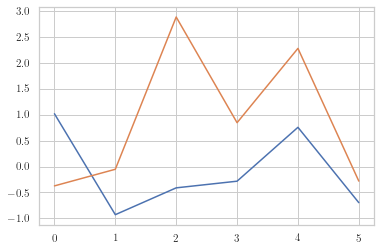

Func distance : 0.304468222558068


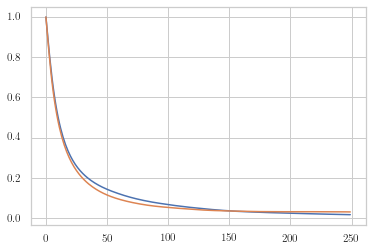

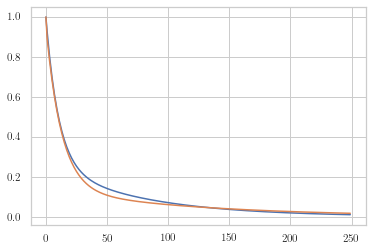

In [77]:
compare(r, 4, 10)

Param distance: 0.6892753190548999


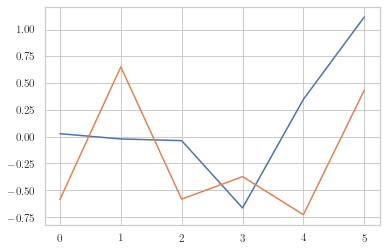

Func distance : 0.334150419830874


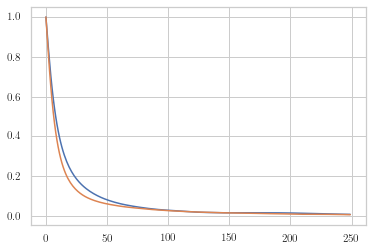

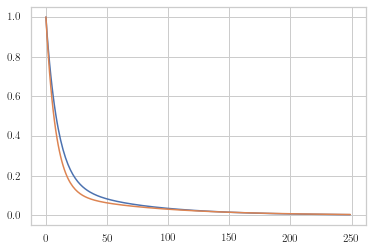

In [78]:
compare(r, 12, 14)

In [72]:
r = filter_stacks(results, tag='C2', direction=None)

Param distance: 2.056966359746071


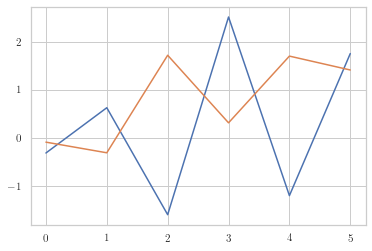

Func distance : 0.5394242538520232


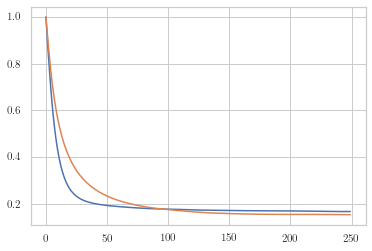

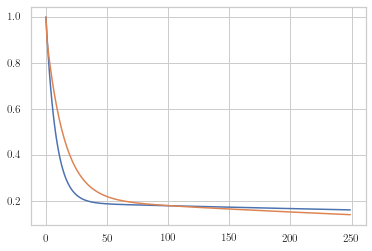

In [73]:
compare(r, 7, 10)

In [41]:
a = extract_stacks(r, 7)
b = extract_stacks(r, 10)

In [42]:
a

{'success': True,
 'x0': [0.2254273522437333,
  0.29452827839021134,
  0.4800443693660553,
  0.6001571320190953,
  0.41722911896268133,
  0.9152243984710625],
 'x': [0.19429920531476866,
  0.8057007946852314,
  4.798653404432425e-18,
  1413.2882457911135,
  8.093683561784907,
  0.9152243984710625],
 'SSE': 0.003593747394806463,
 'exp_data': [1.0,
  0.9181112445038596,
  0.8382512428784252,
  0.7628175434804624,
  0.6935530038399493,
  0.6313269026464078,
  0.5764844207952767,
  0.5285667187998141,
  0.48678903190909606,
  0.4503831885334291,
  0.4187282802140662,
  0.391279610699254,
  0.3675120211917156,
  0.34691093266242057,
  0.32903021758764533,
  0.3134836861546275,
  0.29993290650706944,
  0.2881015863308464,
  0.27775188242403936,
  0.26867743018600654,
  0.2607091880131087,
  0.2536939631680248,
  0.24750699089241532,
  0.24202997122772846,
  0.23716229322452312,
  0.2328288041142879,
  0.22896258188402674,
  0.2255024528388221,
  0.22240729043235127,
  0.21962294895887496,
  

In [27]:
np.linalg.norm(a - b) / np.sqrt(a.shape[0])

2.056966359746071

In [29]:
np.linalg.norm(a_f - b_f) / np.sqrt(a_f.shape[0])

0.5394242538520232

In [ ]:
tag = 'C2'
direction = None
stack_number = 7

In [18]:
f = [item for item in results if ('C2' in item['tag']) and (item['tag'][-1] not in ['X', 'Y', 'Z'])]
X, X_f, Y = make_data(f)
Y = enumerate_stacks(Y)
X, X_f, Y = order_stacks(X, X_f, Y)

In [20]:
a = np.array(f[3]['x'])
aa = np.array(f[3]['exp_data'])

In [28]:
unpack_standard(a)

{'a1': 0.7946345610785984,
 'a2': 0.16534513747149943,
 'a3': 0.04002003805569735,
 'a': 11.01201859996968,
 'b': 299.69171185510925,
 'c': 0.9467985325246305}

In [29]:
unpack_standard(b)

{'a1': 0.23389588529921174,
 'a2': 0.7156014936551383,
 'a3': 0.05050261202489467,
 'a': 420.61711941046644,
 'b': 10.757609194678022,
 'c': 0.735950942241519}

In [21]:
b = np.array(f[7]['x'])
bb = np.array(f[7]['exp_data'])

In [27]:
from opt_utils import f_standard, unpack_standard

In [23]:
one = f_standard(a, 250)
another = f_standard(b, 250)
i = np.arange(250)

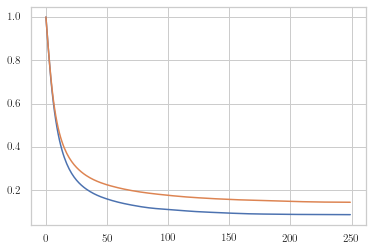

In [25]:
plt.plot(i, aa)
plt.plot(i, bb)
plt.show()

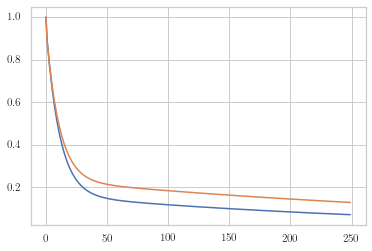

In [24]:
plt.plot(i, one)
plt.plot(i, another)
plt.show()